# Applied Data Science Capstone Project

## Best place to open an Indian Restaurant in the city of Toronto,Canada

### Business Problem: To identify the best location to open an Indian Restaurant in the city of Toronto

## Introduction: 

Indian immigrants have been a part of life in Canada for over a century. As of 2020, there are more than one million Indian citizens in Canada.

Toronto is a major magnet for Indian immigrants. The city is Canada’s economic engine and is also home to some of the continent’s top schools and universities. Opening an Indian restaurant in this city should be an exciting idea for business startup.

In this Project, We will identify the best location to setup an Indian restaurant by analyzing the neighborhoods of Toronto and finding out the borough that has the least number of Indian restaurants. As lesser number implies little competition for the startup.

## Data Acquisition

#### Firstly the data related to different locations(postal codes) of the city,Toronto is acquired from wikipedia page
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

#### The geospatial coordinates (latitudes and longitudes)  of different locations are obtained from this .csv file
https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

#### Four-Square location API has been used to explore and identify the top venues in the neighborhoods


## Webscraping and Data cleansing

First, We will scrape the wiki page to get the basic information of Toronto. In this table below, we can see that many postal codes are 'Not assigned' to any neighborhood.
As part of data pre-processing, we will go with few assumptions that helps in refining the data
1. we shall ignore these 'Not assigned' postal codes as these missing values may mislead the analysis.
2. We will combine the neighborhoods separated by a comma if there exists multiple neighborhoods for single postal code area. Example: M5A Regent Park,Harbourfront
3. If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.

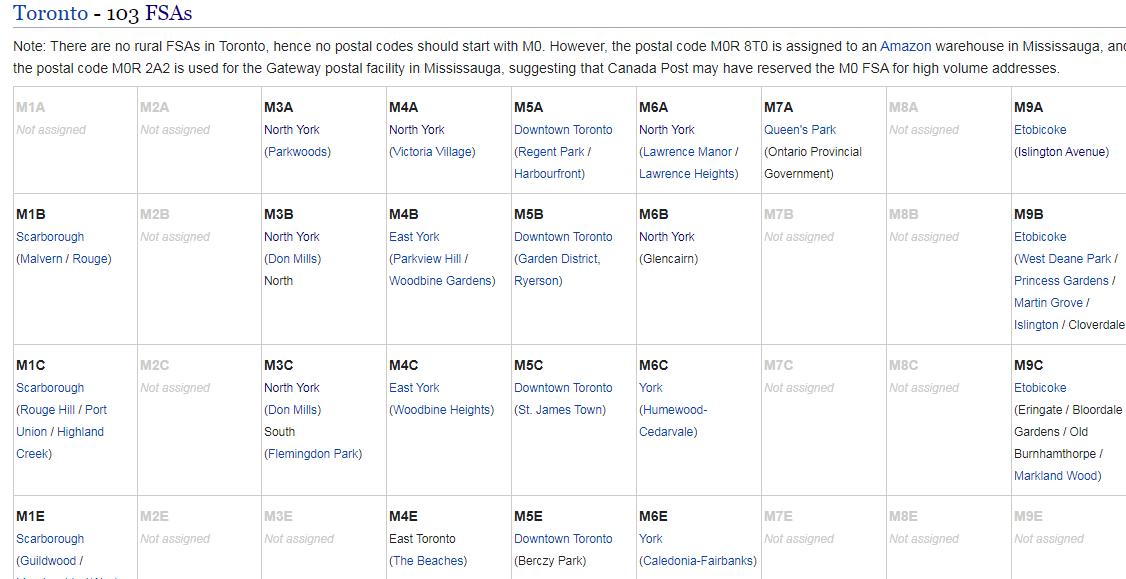

After data preprocessing, we will convert that data into Pandas dataframe for applying machine learning algorithms and for data visualisations.
We will get the output as below



![image](https://user-images.githubusercontent.com/81110444/118713850-14202200-b840-11eb-981e-5276140d74a4.png)

Then we will append the geospatial cooordinates.csv file to get the corresponding location coordinates (Latitude & longitude) of the postal codes. 
The output looks as below

![image](https://user-images.githubusercontent.com/81110444/118714660-43cf2a00-b840-11eb-9654-700782b8fc1e.png)

Now along with the above neighborhood data, we will leverage FourSquare API.
FourSquare API is used to explore these neighborhoods to fetch the details about different types of venues and their location.
This data will be used for our analysis and final result.
The sample data below:

![image](https://user-images.githubusercontent.com/81110444/118714824-7aa54000-b840-11eb-943c-baa52b70f6b9.png)

using Folium maps and K-means clustering we can identify clustered neighborhoods on maps  as below

![image](https://user-images.githubusercontent.com/81110444/118714956-a88a8480-b840-11eb-94cc-2c80abb8ba7f.png)

## Methodology

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from bs4 import BeautifulSoup
import requests
from requests import get

### Scraping the webpage

In [4]:
url= 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_content = requests.get(url).text
soup = BeautifulSoup(html_content, "lxml")

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [6]:
# print(table_contents)
df=pd.DataFrame(table_contents)

In [7]:
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [8]:
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [9]:
df.shape

(103, 3)

#### Appending location coordinates .csv

In [10]:
url= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'

In [11]:
!wget -q -O 'Geospatial_Coordinates.csv' url
print('Data downloaded!')

Data downloaded!


In [12]:
df2=pd.read_csv(url,sep=',')

In [13]:
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
df1 = pd.merge(df, df2, left_on='PostalCode', right_on = 'Postal Code')
df1.drop('Postal Code', inplace=True, axis=1)

In [15]:
df1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [16]:
df1.shape

(103, 5)

In [19]:
df1

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [20]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df1['Borough'].unique()),
        df1.shape[0]
    )
)

The dataframe has 15 boroughs and 103 neighborhoods.


In [21]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

# All requested packages already installed.



In [22]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [23]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



#### Map of Toronto city

In [24]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df1['Latitude'], df1['Longitude'], df1['Borough'], df1['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [25]:
CLIENT_ID = 'RCBY3O1XP3WGRNV13IKLS1PFRCORZI4IDWJIY1X3PKK00CX5' # your Foursquare ID
CLIENT_SECRET = 'EXKVP14LMIHYZQKAMAR10XFK4M2U5XOBCVE1VDFPQNMC3XPO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RCBY3O1XP3WGRNV13IKLS1PFRCORZI4IDWJIY1X3PKK00CX5
CLIENT_SECRET:EXKVP14LMIHYZQKAMAR10XFK4M2U5XOBCVE1VDFPQNMC3XPO


In [26]:
import json

In [27]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [29]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#### Let's explore the first neighborhood in our dataframe

In [30]:
df1.loc[0,'Neighborhood']

'Parkwoods'

In [31]:
neighborhood_latitude = df1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df1.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Now, let's get the top 100 venues that are in 'Parkwoods' within a radius of 500 meters

In [32]:
LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RCBY3O1XP3WGRNV13IKLS1PFRCORZI4IDWJIY1X3PKK00CX5&client_secret=EXKVP14LMIHYZQKAMAR10XFK4M2U5XOBCVE1VDFPQNMC3XPO&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [33]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60a61fe23b12ae1b9b1d0aef'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

#### we know that all the information is in the items key. Before we proceed, let's borrow the get_category_type function from the Foursquare lab.

In [34]:
!pip install -U numpy

!pip install -U pandas

!pip install -U scipy

!pip install -U scikit-learn

!pip install -U imbalanced-learn

In [35]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Now we are ready to clean the json and structure it into a pandas dataframe.

In [36]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,KFC,Fast Food Restaurant,43.754387,-79.333021
2,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### to run the above function on each neighborhood and create a new dataframe called Toronto_venues

In [38]:
Toronto_venues = getNearbyVenues(names=df1['Neighborhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

#### Let's check the size of the resulting dataframe

In [39]:
print(Toronto_venues.shape)
Toronto_venues.head()

(2130, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


#### Let's check how many venues were returned for each neighborhood

In [40]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
Berczy Park,60,60,60,60,60,60
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17


#### Let's find out how many unique categories can be curated from all the returned venues

In [41]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 276 uniques categories.


Analyzing Each Neighborhood
We will anayze each Neighborhood with venues informations

In [42]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head(20)

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### And let's examine the new dataframe size

In [43]:
Toronto_onehot.shape

(2130, 276)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [44]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

#### Let's confirm the new size

In [45]:
Toronto_grouped.shape

(101, 276)

#### Let's print each neighborhood along with the top 5 most common venues

In [46]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant  0.25
1             Breakfast Spot  0.25
2                     Lounge  0.25
3         Chinese Restaurant  0.25
4                Yoga Studio  0.00


----Alderwood, Long Branch----
         venue  freq
0  Pizza Place  0.25
1   Playground  0.12
2          Gym  0.12
3  Coffee Shop  0.12
4          Pub  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                       Bank  0.09
1                Coffee Shop  0.09
2                       Park  0.04
3                      Diner  0.04
4  Middle Eastern Restaurant  0.04


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2   Chinese Restaurant  0.25
3                 Bank  0.25
4          Music Venue  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Pizza Place  0.08
1         Coffee Shop  0.08
2          Restau

#### Let's put that into a pandas dataframe

#### First, let's write a function to sort the venues in descending order

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Chinese Restaurant,Yoga Studio,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant
1,"Alderwood, Long Branch",Pizza Place,Playground,Gym,Coffee Shop,Pub,Sandwich Place,Pharmacy,Hookah Bar,Nail Salon,Middle Eastern Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Park,Diner,Middle Eastern Restaurant,Shopping Mall,Mobile Phone Shop,Sandwich Place,Fried Chicken Joint,Frozen Yogurt Shop
3,Bayview Village,Japanese Restaurant,Café,Chinese Restaurant,Bank,Music Venue,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark
4,"Bedford Park, Lawrence Manor East",Pizza Place,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Pet Store,Pub,Café,Butcher


#### Let's find out which neighborhood has the first most common venue as Indian Restaurant

In [97]:
neighborhoods_venues_sorted_ind = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains('Indian Restaurant')]
neighborhoods_venues_sorted_ind

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,0,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Light Rail Station,Thrift / Vintage Store,Yoga Studio,Modern European Restaurant,Motel,Moroccan Restaurant


Dorset Park, Wexford Heights, Scarborough Town... 

 #### Out of 2130 different venues lets find out the venues that are of category 'Restaurant'

In [51]:
Toronto_venues_restaurant = Toronto_venues[Toronto_venues['Venue Category'].str.contains('Restaurant')]

In [52]:
print(Toronto_venues_restaurant.shape)
Toronto_venues_restaurant.head()

(483, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
12,"Regent Park, Harbourfront",43.654260,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
33,"Regent Park, Harbourfront",43.654260,-79.360636,El Catrin,43.650601,-79.358920,Mexican Restaurant
37,"Regent Park, Harbourfront",43.654260,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant


In [53]:
Toronto_venues_restaurant.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,2,2,2,2,2,2
"Bathurst Manor, Wilson Heights, Downsview North",3,3,3,3,3,3
Bayview Village,2,2,2,2,2,2
"Bedford Park, Lawrence Manor East",11,11,11,11,11,11
Berczy Park,12,12,12,12,12,12
"Brockton, Parkdale Village, Exhibition Place",2,2,2,2,2,2
Cedarbrae,3,3,3,3,3,3
Central Bay Street,16,16,16,16,16,16
Christie,2,2,2,2,2,2


In [54]:
print(Toronto_venues_restaurant.shape)

(483, 7)


In [55]:
Toronto_venues_restaurant_1 =Toronto_venues_restaurant.groupby(['Neighborhood','Venue Category']).count().reset_index()

In [56]:
print(Toronto_venues_restaurant_1.shape)
Toronto_venues_restaurant_1.head()

(339, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Agincourt,Chinese Restaurant,1,1,1,1,1
1,Agincourt,Latin American Restaurant,1,1,1,1,1
2,"Bathurst Manor, Wilson Heights, Downsview North",Middle Eastern Restaurant,1,1,1,1,1
3,"Bathurst Manor, Wilson Heights, Downsview North",Restaurant,1,1,1,1,1
4,"Bathurst Manor, Wilson Heights, Downsview North",Sushi Restaurant,1,1,1,1,1


#### Out of 2130 different venues, 483 venues are of 'Restaurant' category. Lets check the count of venues in the neighborhoods having restaurants.


In [57]:
summary = Toronto_venues_restaurant.groupby(['Neighborhood']).count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Neighborhood Latitude', 'Neighborhood Longitude','Venue', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary

,Neighborhood,Count
0,"Malvern, Rouge",1
1,Forest Hill North & West,1
2,Glencairn,1
3,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",1
4,"Cliffside, Cliffcrest, Scarborough Village West",1
5,"Lawrence Manor, Lawrence Heights",1
6,"Mimico NW, The Queensway West, South of Bloor,...",1
7,"Dufferin, Dovercourt Village",1
8,Parkwoods,1
9,Roselawn,1


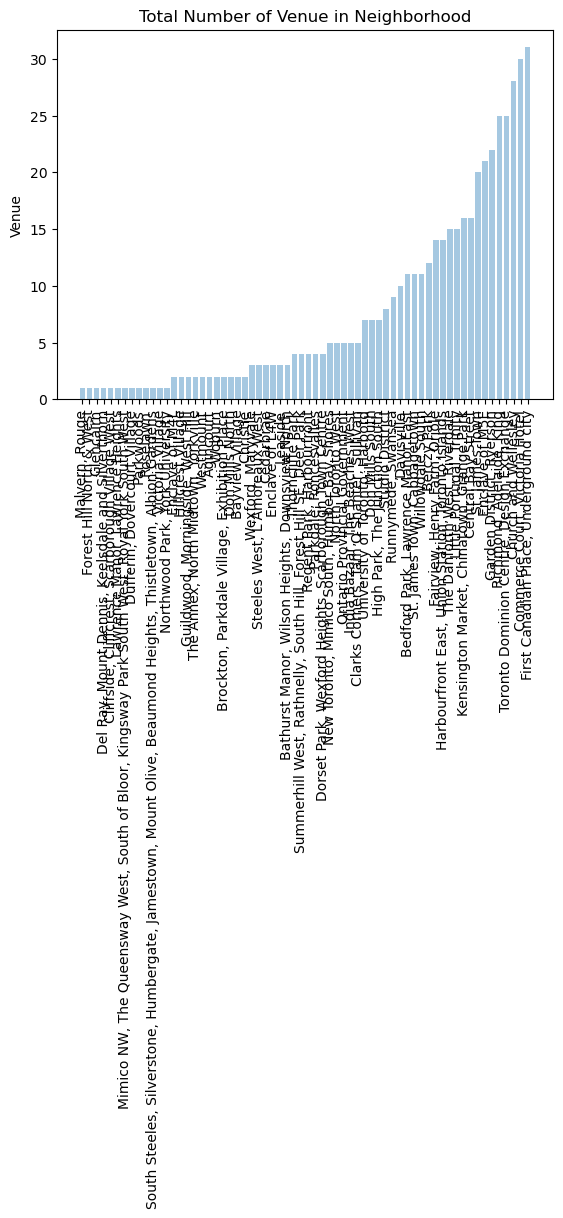

In [58]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = summary.Neighborhood
y_pos = np.arange(len(objects))
performance = summary.Count

plt.bar(y_pos, performance, align='center', alpha=0.4, width = 0.8)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Neighborhood')
plt.xticks(rotation=90)

plt.show()

#### List of Neighborhoods having Indian Restaurants

In [59]:
Toronto_venues_restaurant_ind =Toronto_venues_restaurant_1[Toronto_venues_restaurant_1 ['Venue Category'].str.contains('Indian')]

print(Toronto_venues_restaurant_ind.shape)
Toronto_venues_restaurant_ind


(13, 7)


,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
11,"Bedford Park, Lawrence Manor East",Indian Restaurant,1,1,1,1,1
20,Berczy Park,Indian Restaurant,1,1,1,1,1
33,Central Bay Street,Indian Restaurant,1,1,1,1,1
51,Church and Wellesley,Indian Restaurant,1,1,1,1,1
82,Davisville,Indian Restaurant,1,1,1,1,1
98,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,2,2,2,2,2
110,Enclave of M5E,Indian Restaurant,1,1,1,1,1
160,"Harbourfront East, Union Station, Toronto Islands",Indian Restaurant,1,1,1,1,1
273,"St. James Town, Cabbagetown",Indian Restaurant,1,1,1,1,1
292,"The Annex, North Midtown, Yorkville",Indian Restaurant,1,1,1,1,1


#### Merging the dataframes to get the number of venues in the Neighborhoods having Indian Restaurants

In [60]:
result = pd.merge(Toronto_venues_restaurant_ind,
                 summary,
                 on='Neighborhood', 
                 how='left')

result =result.drop(['Venue Category','Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude'], axis=1)
result = result.sort_values('Count').reset_index(drop=True)

result 

,Neighborhood,Count
0,"The Annex, North Midtown, Yorkville",2
1,Woburn,2
2,"Dorset Park, Wexford Heights, Scarborough Town...",4
3,Thorncliffe Park,4
4,Davisville,10
5,"Bedford Park, Lawrence Manor East",11
6,"St. James Town, Cabbagetown",11
7,Berczy Park,12
8,"Harbourfront East, Union Station, Toronto Islands",14
9,"The Danforth West, Riverdale",15


#### Bar chart for visualization

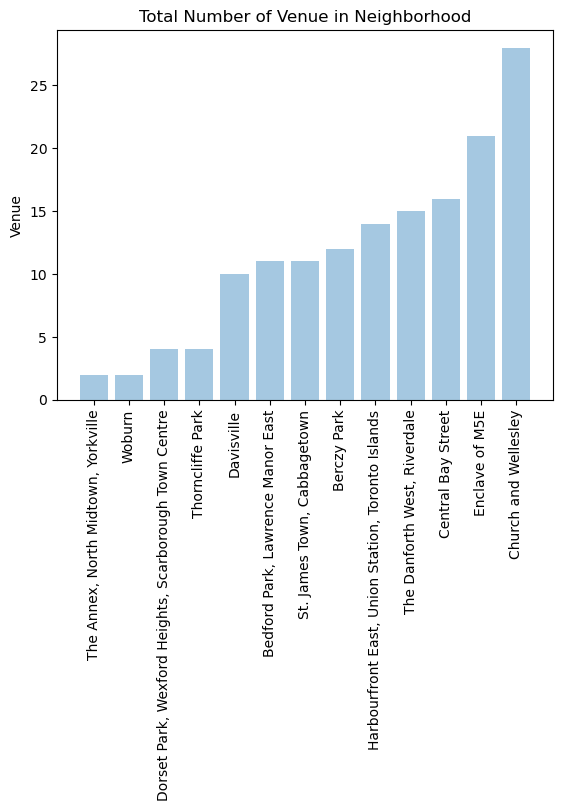

In [61]:
objects = result.Neighborhood
y_pos = np.arange(len(objects))
performance = result.Count

plt.bar(y_pos, performance, align='center', alpha=0.4)
plt.xticks(y_pos, objects)
plt.ylabel('Venue')
plt.title('Total Number of Venue in Neighborhood')
plt.xticks(rotation=90)

plt.show()


#### The top 10 most common venues in those neighborhoods

In [62]:
result_top_venues = pd.merge(Toronto_venues_restaurant_ind,neighborhoods_venues_sorted,on='Neighborhood',how='left')

In [73]:
result_top_venues

,Neighborhood,Venue Category,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bedford Park, Lawrence Manor East",Indian Restaurant,1,1,1,1,1,Pizza Place,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Pet Store,Pub,Café,Butcher
1,Berczy Park,Indian Restaurant,1,1,1,1,1,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Farmers Market,Beer Bar,Pharmacy,Beach
2,Central Bay Street,Indian Restaurant,1,1,1,1,1,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant,Pizza Place,Bubble Tea Shop,Burger Joint,Salad Place,Falafel Restaurant
3,Church and Wellesley,Indian Restaurant,1,1,1,1,1,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Mediterranean Restaurant,Pub,Fast Food Restaurant,Men's Store,Yoga Studio
4,Davisville,Indian Restaurant,1,1,1,1,1,Pizza Place,Sandwich Place,Dessert Shop,Coffee Shop,Sushi Restaurant,Café,Italian Restaurant,Gym,Diner,Restaurant
5,"Dorset Park, Wexford Heights, Scarborough Town...",Indian Restaurant,2,2,2,2,2,Indian Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Light Rail Station,Thrift / Vintage Store,Yoga Studio,Modern European Restaurant,Motel,Moroccan Restaurant
6,Enclave of M5E,Indian Restaurant,1,1,1,1,1,Coffee Shop,Seafood Restaurant,Cocktail Bar,Italian Restaurant,Bakery,Café,Restaurant,Hotel,Japanese Restaurant,Beer Bar
7,"Harbourfront East, Union Station, Toronto Islands",Indian Restaurant,1,1,1,1,1,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Brewery,Sporting Goods Shop,Fried Chicken Joint,Restaurant,Scenic Lookout
8,"St. James Town, Cabbagetown",Indian Restaurant,1,1,1,1,1,Pizza Place,Café,Coffee Shop,Italian Restaurant,Chinese Restaurant,Pub,Restaurant,Bakery,Deli / Bodega,Market
9,"The Annex, North Midtown, Yorkville",Indian Restaurant,1,1,1,1,1,Sandwich Place,Café,Coffee Shop,History Museum,BBQ Joint,Pharmacy,Park,Pub,Donut Shop,Burger Joint


## Cluster Neighborhoods

#### Run k-means to cluster the neighborhood into 3 clusters.

In [63]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [81]:
# set number of clusters
kclusters = 3

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
# kmeans.labels_[0:10] 

labels = kmeans.labels_
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1], dtype=int32)

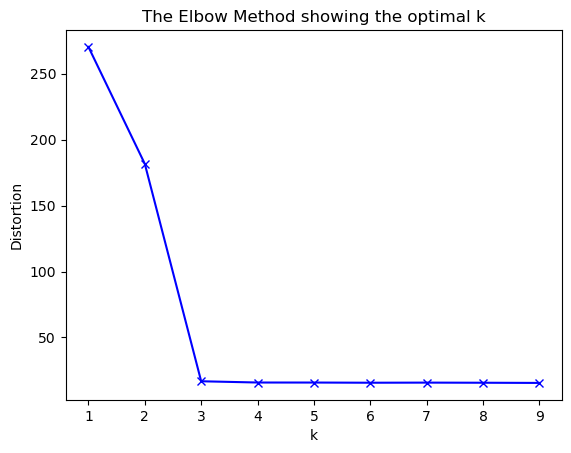

In [76]:
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(Toronto_grouped_clustering)
    #kmeanModel.fit(Toronto_grouped_clustering)
    distortions.append(sum(np.min(cdist(Toronto_grouped_clustering, kmeanModel.cluster_centers_, 'canberra'), axis=1)) / Toronto_grouped_clustering.shape[0])

#There are different metric distance function for spatial distance. 
#I choose correlation instead of euclidean because the canberra function gives me more clear view of elbow break point.

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [82]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')


# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_


toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,M1S,Scarborough,Agincourt,43.794200,-79.262029,1,Latin American Restaurant,Breakfast Spot,Lounge,Chinese Restaurant,Yoga Studio,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant
93,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,1,Pizza Place,Playground,Gym,Coffee Shop,Pub,Sandwich Place,Pharmacy,Hookah Bar,Nail Salon,Middle Eastern Restaurant
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,1,Bank,Coffee Shop,Park,Diner,Middle Eastern Restaurant,Shopping Mall,Mobile Phone Shop,Sandwich Place,Fried Chicken Joint,Frozen Yogurt Shop
39,M2K,North York,Bayview Village,43.786947,-79.385975,1,Japanese Restaurant,Café,Chinese Restaurant,Bank,Music Venue,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark
55,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,1,Pizza Place,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Pet Store,Pub,Café,Butcher


In [83]:
count_venue = toronto_merged
count_venue = count_venue.drop(['PostalCode','Borough','Neighborhood', 'Latitude', 'Longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue,Airport,Airport Service,American Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Breakfast Spot,Cafeteria,Café,Caribbean Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Dance Studio,Discount Store,Electronics Store,Fast Food Restaurant,Field,Greek Restaurant,Grocery Store,Hardware Store,Health Food Store,Hobby Shop,Home Service,Indian Restaurant,Japanese Restaurant,Jewelry Store,Latin American Restaurant,Massage Studio,Medical Center,Mediterranean Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Nail Salon,Park,Pharmacy,Pizza Place,Playground,Pool,Ramen Restaurant,Restaurant,Sandwich Place,Sporting Goods Shop,Truck Stop,Yoga Studio
0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,2,1,2,0,1,1,6,1,3,19,1,1,1,1,0,4,1,1,3,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,9,1,1,1,1,3,1,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,1,0,0,0,0,0,0,0


Text(0, 0.5, 'Clusters')

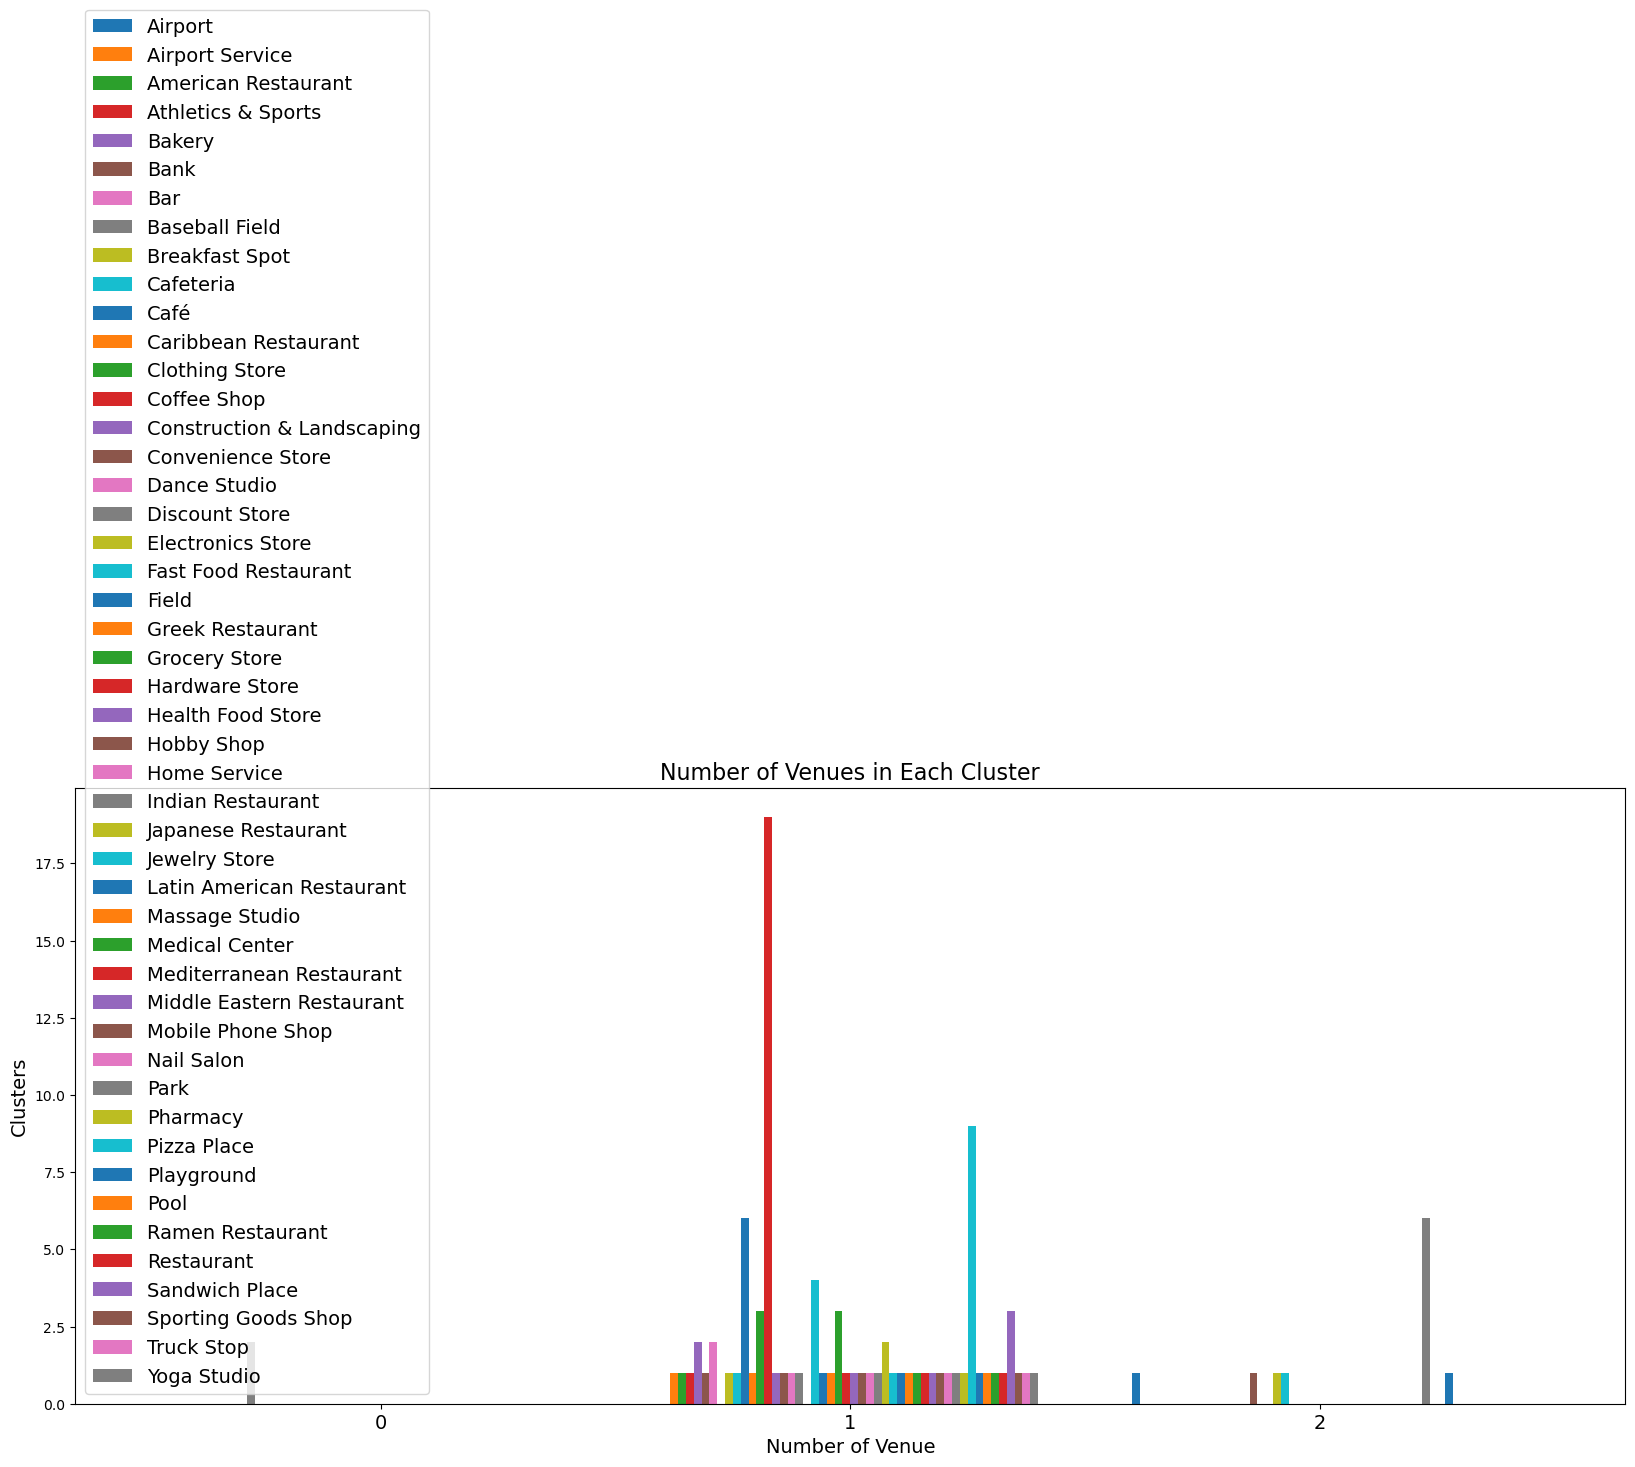

In [84]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)



When we examine above graph we can label each cluster as follows:

Cluster 0 : "Baseball Field"
Cluster 1 : "Coffee Shop"
Cluster 2 : "Park"
We can now assign those new labels to existing label of clusters:

#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [85]:
Cluster_labels = {'Clusters': [0,1,2], 'Labels': ["Baseball Field","Coffee Shop","Park"]}
Cluster_labels = pd.DataFrame(data=Cluster_labels)
Cluster_labels

,Clusters,Labels
0,0,Baseball Field
1,1,Coffee Shop
2,2,Park


In [86]:
final_result= pd.merge(toronto_merged, 
                    Cluster_labels[['Clusters', 'Labels']],
                    left_on = 'Cluster Labels',
                    right_on = 'Clusters',
                    how = 'left')

In [89]:
final_result = final_result.drop(['Clusters'], axis=1)
final_result.head(3)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
0,M1S,Scarborough,Agincourt,43.794200,-79.262029,1,Latin American Restaurant,Breakfast Spot,Lounge,Chinese Restaurant,Yoga Studio,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Coffee Shop
1,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,1,Pizza Place,Playground,Gym,Coffee Shop,Pub,Sandwich Place,Pharmacy,Hookah Bar,Nail Salon,Middle Eastern Restaurant,Coffee Shop
2,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,1,Bank,Coffee Shop,Park,Diner,Middle Eastern Restaurant,Shopping Mall,Mobile Phone Shop,Sandwich Place,Fried Chicken Joint,Frozen Yogurt Shop,Coffee Shop


#### Finally, let's visualize the resulting clusters

In [66]:
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].fillna(0).astype('int') 

In [102]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,label in zip(final_result['Latitude'], final_result['Longitude'], final_result['Neighborhood'], final_result['Cluster Labels'], final_result['Labels'] ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

#### Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster.
#### Based on the defining categories, you can then assign a name to each cluster. 

### Cluster 1

In [91]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,0,Baseball Field,Furniture / Home Store,Yoga Studio,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Museum
101,Etobicoke,0,Baseball Field,Yoga Studio,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Miscellaneous Shop,Museum


### Cluster 2

In [92]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
78,Scarborough,1,Latin American Restaurant,Breakfast Spot,Lounge,Chinese Restaurant,Yoga Studio,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant
93,Etobicoke,1,Pizza Place,Playground,Gym,Coffee Shop,Pub,Sandwich Place,Pharmacy,Hookah Bar,Nail Salon,Middle Eastern Restaurant
28,North York,1,Bank,Coffee Shop,Park,Diner,Middle Eastern Restaurant,Shopping Mall,Mobile Phone Shop,Sandwich Place,Fried Chicken Joint,Frozen Yogurt Shop
39,North York,1,Japanese Restaurant,Café,Chinese Restaurant,Bank,Music Venue,Museum,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark
55,North York,1,Pizza Place,Coffee Shop,Restaurant,Sandwich Place,Italian Restaurant,Thai Restaurant,Pet Store,Pub,Café,Butcher
20,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Farmers Market,Beer Bar,Pharmacy,Beach
58,Scarborough,1,Café,College Stadium,General Entertainment,Skating Rink,Yoga Studio,Molecular Gastronomy Restaurant,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark
43,West Toronto,1,Café,Breakfast Spot,Coffee Shop,Intersection,Burrito Place,Stadium,Furniture / Home Store,Bar,Bakery,Climbing Gym
87,Downtown Toronto,1,Airport Service,Airport Terminal,Airport Lounge,Plane,Sculpture Garden,Rental Car Location,Harbor / Marina,Boutique,Boat or Ferry,Airport Gate
26,Scarborough,1,Caribbean Restaurant,Bakery,Bank,Thai Restaurant,Athletics & Sports,Hakka Restaurant,Gas Station,Fried Chicken Joint,Monument / Landmark,Movie Theater


### Cluster 3

In [93]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,York,2,Park,Women's Store,Pool,Mobile Phone Shop,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
40,North York,2,Airport,Park,Yoga Studio,Miscellaneous Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop
61,Central Toronto,2,Park,Bus Line,Swim School,Yoga Studio,Modern European Restaurant,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Mobile Phone Shop
85,Scarborough,2,Playground,Intersection,Park,Modern European Restaurant,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Mobile Phone Shop
83,Central Toronto,2,Park,Tennis Court,Yoga Studio,Mobile Phone Shop,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
0,North York,2,Fast Food Restaurant,Park,Food & Drink Shop,Yoga Studio,Mobile Phone Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
91,Downtown Toronto,2,Park,Playground,Trail,Mobile Phone Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop
35,East York/East Toronto,2,Convenience Store,Park,Yoga Studio,Mobile Phone Shop,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
64,York,2,Park,Convenience Store,Yoga Studio,Mobile Phone Shop,Movie Theater,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant
52,North York,2,Park,Yoga Studio,Miscellaneous Shop,Motel,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Mobile Phone Shop,Middle Eastern Restaurant
